In [1]:
forget()
import statistics
import math
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from matplotlib.ticker import MaxNLocator

# COMENÇA EL PROGRAMA, NO CAL FER RES AQUÍ
global gravedad
global incerteses_sw

incerteses_sw =[]
gravedad = 9.8

class Measure:
    objects = []
    
    def __init__(self,variable_name, name, mag_inc, unitats):
#         assert (magnitude.parent() == RR) and (incertesa.parent() == RR) and (isinstance(units, str)
        self.name = name
    
        self.var_name = variable_name
        self.var_inc_name = f"{variable_name}_inc"
        self.var = var(variable_name)
        self.var_inc = var(f"{variable_name}_inc")
        
        self.magnitude = mag_inc[0]
        self.incertesa = mag_inc[1]
        self.unitats = unitats
        
        Measure.objects.append(self)
        
                                                                              
    def __repr__(self):
        if type(self.magnitude) == float:
            return repr(f"{(self.name).capitalize()}: ({self.magnitude} +/- {self.incertesa}) {self.unitats}")            
        else:
            return repr(f"{(self.name).capitalize()}: ({self.magnitude.n()} +/- {self.incertesa.n()}) {self.unitats}")
    
class Measure_list(Measure):
    def __init__(self,variable_name, name, valors,inc_inst, unitats):
        assert isinstance(valors, list), "fica una llista"
        suma = 0
        val_prom = mean(valors)
        num = len(valors) - 1
        for x in valors:
            suma += (val_prom-x)**2
            
        stdev = sqrt(suma/num)
        inc_est = stdev/sqrt(num + 1)
        
        inc = sqrt((inc_est**2) + (inc_inst**2))
        Measure.__init__(self, variable_name, name, [val_prom,inc], unitats)
        
        self.stdev = stdev
        self.inc_ins = inc_inst
        
    def __repr__(self):
        return f"{(self.name).capitalize()}: ({self.magnitude.n()} +/- {self.incertesa.n()}) {self.unitats}\n\t[Stdev : {self.stdev.n()}, Inc. Instrumental:{self.inc_ins}]"

class Physics_magnitude:
#    gravity = 9.8

    def __init__(self, equation, variables):
        # Initializing values
        self.formula = equation
#         Both following have same order, contain var values
        self.variable_list = [variable.var for variable in variables]
        self.variable_inc_list = [variable.var_inc for variable in variables]
        
        self.variable_and_inc_list = []
        for variable, variable_inc in zip(self.variable_list, self.variable_inc_list):
            self.variable_and_inc_list.extend([variable,variable_inc])
            
#         Comprovem que hi ha el mateix NOMBRE de variables a l'equació proporcionada
        try:
            temp = self.formula(1)
            for x in range(1,len(variables)):
                temp = temp(1)
        except:
            ValueError("El nombre de variables de la funció i les proporcionades no coincideix")
            
        # Defining incertesa
        self.incertesa= self.incertesa_combinada_simbolica()
    
    def incertesa_combinada_simbolica(self):
        inc_comb = 0
        # CAMBIAR CON LO AHORA HECHO DE INCERTESES
        for variable, variable_inc in zip(self.variable_list, self.variable_inc_list):
            inc_comb += ((self.formula).diff(variable)*variable_inc)**2 
        inc_comb = sqrt(inc_comb)
        
#         show(self.formula)
        incerteses_sw.append(inc_comb)
        
        for variable in self.variable_list:
            inc_comb = variable * inc_comb
        return inc_comb

    def evaluate(self, valores):
        #evalua en el orden pasado a la clase llamada
        # Preparando carnita: (valores tiene que ser un objecto Measure)
        account = []
        for valor in valores:
            account.extend([(valor.var_name, valor.magnitude), (valor.var_inc_name, valor.incertesa)])
        
        # Eliminamos posibles repeticiones de valores para que, en evaluar, no se repita la misma evaluación
        account = set(account)
        account = list(account)
        
        account.sort() # Tiene que estar según el orden alfabético
#         show("Account", account)
#         show("Formula", self.formula,"Incertesa", self.incertesa)
        temp1 = self.formula
        temp2 = self.incertesa
#         show("This is temp1", temp1)
        for x in account:
#             show(temp2, "evaluated at", x)
            temp2 = (temp2)(x[1])
            if  not ((str(x[0]))[-4:] == "_inc"):
                temp2 = (temp2)/(x[1])
#             show("Result:",temp2)
            
            
            if  not ((str(x[0]))[-4:] == "_inc"):
#                 show(temp1, "evaluated at", x)
                temp1 = (temp1)(x[1])
#                 show("temp1 result", temp1)
        return [temp1,temp2]

    def __repr__(self):
        return repr(f"Formula: {self.formula}")

def formulador(formula,dades,name,symbol,units): #Importante, las vars han de coincidir
    if isinstance(dades, Measure): dades = [dades]
    magnitud = Physics_magnitude(formula, dades)
    return Measure(symbol, name, magnitud.evaluate(dades),units)


# -----------------------------------------------------------------
# OLD REGRESSION DISPLAYER
# -----------------------------------------------------------------
def linear_regression(x,y,title):
    # Perform linear regression
    B, A, r, p_value, std_err = linregress(x, y)
    A = float(A)
    B = float(B)
    r = float(r)
    # Calculate uncertainties
    B_inc, A_inc = uncertainties(x, y, B, A)
    B_inc = float(B_inc)
    A_inc = float(A_inc)
    # Plot the linear regression
    plt.scatter(x, y)
    plt.plot(x, A + B*np.array(x), color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('foo.png')
    plt.ylim([0, 4500])
    plt.show()
    return Measure(f"A_{title}",f"A_{title}", [A, A_inc], " "), Measure(f"B_{title}",f"B_{title}", [B, B_inc], " "), Measure(f"r_{title}",f"r_{title}", [r, 0], " ")

def uncertainties(x, y, slope, intercept):
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x*y)
    sum_x_squared = np.sum(x**2)
    delta = n*sum_x_squared - sum_x**2
    sigma2 = 0
    for xa,ya in zip(x,y):
        sigma2+= (ya- intercept - slope*xa)**2
    sigma2 = sigma2/(n-2)
    uncertainty_slope = sqrt(sigma2*n/delta)
    uncertainty_intercept = sqrt(sigma2* sum_x_squared/delta)
    return uncertainty_slope, uncertainty_intercept

# -----------------------------------------------------------------
# REGRESSION DISPLAYER
# -----------------------------------------------------------------
def regresio(data, x_label, x_units, y_label, y_units, title):
    # Extract relevant data from input
    x_values = [float(x) for x, _ in data]
    magnitudes = [measure.magnitude for _, measure in data]
    uncertainties = [measure.incertesa for _, measure in data]

    # Perform linear regression
    slope, intercept = np.polyfit(x_values, magnitudes, 1)

    # Extend the regression line by creating a broader range of x values
    x_values_extended = np.linspace(min(x_values), max(x_values) * 1.2, 100)
    regression_line = [slope * x + intercept for x in x_values_extended]

    # Compute the regression coefficient (R^2)
    correlation_matrix = np.corrcoef(x_values, magnitudes)
    r_squared = correlation_matrix[0, 1] ** 2
    
    # Create a scatter plot with stylized error bars and with a larger size
    fig, ax = plt.subplots(figsize=(10, 6))  
    ax.errorbar(x_values, magnitudes, yerr=uncertainties, fmt='o', color='black', 
                elinewidth=1, ecolor='darkred', capsize=2.5, markersize=4)
    
    # Plot the regression line
    ax.plot(x_values_extended, regression_line, color='red', 
            label=f'Recta de regressió\ny = {slope:.2f}x + {intercept:.2f}\n$r^2$ = {r_squared:.2f}')
    
    # Adding labels and title
    ax.set_ylabel(f'{y_label} ({y_units})')
    ax.set_xlabel(f'{x_label} ({x_units})')
    ax.set_title(title)
    ax.yaxis.grid(False)  
    
    # Set axis limits to include (0,0) and to center the graph
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    # Adjust the ticks to not display 0 at the origin and format properly
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    def format_ticks(ticks):
        formatted_ticks = []
        for tick in ticks:
            if tick == 0.0:
                formatted_ticks.append('')
            elif isinstance(tick, float) and tick.is_integer():
                formatted_ticks.append(str(int(tick)))
            else:
                formatted_ticks.append(str(tick))
        return formatted_ticks
    
    ax.set_xticklabels(format_ticks(ax.get_xticks()))
    ax.set_yticklabels(format_ticks(ax.get_yticks()))

    # Save the plot to a file and show it
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.savefig(title + '.png', dpi=300, bbox_inches='tight')  
    plt.show()




# -----------------------------------------------------------------
# GRAPH DISPLAYER
# -----------------------------------------------------------------
def graph_display(data, x_label, x_units, y_label, y_units, title):
    """
    Display a scatter plot with stylized vertical error bars for the given data.

    Parameters:
        data: list[tuple[str, Measure]]
            Data points as a list of (x, Measure) tuples.
        x_label: str
            Label for the x-axis.
        x_units: str
            Units for the x-axis.
        y_label: str
            Label for the y-axis.
        y_units: str
            Units for the y-axis.
        title: str
            Title for the plot.
    """
    # Extract relevant data from input
    x_values = [x for x, _ in data]
    magnitudes = [measure.magnitude for _, measure in data]
    uncertainties = [measure.incertesa for _, measure in data]

    # Create a scatter plot with stylized error bars and with a larger size
    fig, ax = plt.subplots(figsize=(10, 6))  
    ax.errorbar(x_values, magnitudes, yerr=uncertainties, fmt='o', color='black', 
                elinewidth=1, ecolor='darkred', capsize=2.5, markersize=4)

    # Adding labels and title
    ax.set_ylabel(f'{y_label} ({y_units})')
    ax.set_xlabel(f'{x_label} ({x_units})')
    ax.set_title(title)
    ax.yaxis.grid(False)  
    
    # Set x-axis limits to start at 0
    ax.set_xlim(left=0)
    
    # Set y-axis limits to start at 0 only when all y-values are non-negative
    if all(magnitude >= 0 for magnitude in magnitudes):
        ax.set_ylim(bottom=0)
        
    # Adjust the ticks to not display 0 at the origin and format properly
    x_ticks = np.array(ax.get_xticks()).tolist()
    y_ticks = np.array(ax.get_yticks()).tolist()
    
    def format_ticks(ticks):
        formatted_ticks = []
        for tick in ticks:
            if tick == 0.0:
                formatted_ticks.append('')
            elif isinstance(tick, float):  # Check if tick is float before using is_integer
                if tick.is_integer():
                    formatted_ticks.append(str(int(tick)))
                else:
                    formatted_ticks.append(str(tick))
            else:
                formatted_ticks.append(str(tick))
        return formatted_ticks

    
    ax.set_xticklabels(format_ticks(x_ticks))
    ax.set_yticklabels(format_ticks(y_ticks))

    # Save the plot to a file and show it
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.savefig(title + '.png', dpi=300, bbox_inches='tight')  
    plt.show()


# -----------------------------------------------------------------
# TABLE DISPLAYER
# -----------------------------------------------------------------

def format_number(number):
    """
    Format number to a string, handling both symbolic and floating point numbers.
    
    Parameters:
    - number: either a floating point number or a symbolic expression
    
    Returns:
    - A string representation of the number, without unnecessary trailing zeros.
    """
    # Handle symbolic expressions
    if hasattr(number, 'n'):
        # Convert symbolic expression to numerical value
        numerical_value = number.n()
        # Format numerical value
        str_num = f"{numerical_value}"
        return str_num.rstrip('0').rstrip('.') if '.' in str_num else str_num
    
    # Handle floating point numbers
    elif isinstance(number, (float, int)):
        str_num = f"{number}"
        return str_num.rstrip('0').rstrip('.') if '.' in str_num else str_num
    
    # Handle other types
    else:
        return str(number)

def crear_taula(measures, attr='name'):
    """
    Display measures in a sorted order based on the specified attribute, using HTML table.
    
    Parameters:
    - measures: list of Measure or Measure_list objects
    - attr: attribute to sort by ('magnitude', 'name', etc.)
    """
    # Sort measures by the specified attribute
    sorted_measures = sorted(measures, key=lambda x: getattr(x, attr))
    
    # Start creating HTML content
    html_content = "<table style='border: 1px solid black; width: 100%;'>"
    html_content += "<tr><th>Name</th><th>Magnitude</th><th>Incertesa</th><th>Units</th><th>Incertesa Instrumental (if available)</th></tr>"
    
    # Add rows to the table for each measure
    for measure in sorted_measures:
        magnitude_str = format_number(measure.magnitude)
        incertesa_str = format_number(measure.incertesa)
        
        if isinstance(measure, Measure_list):
            inc_inst_str = format_number(measure.inc_ins)
        else:
            inc_inst_str = "N/A"
        
        html_content += f"<tr><td>{measure.name}</td><td>{magnitude_str}</td><td>{incertesa_str}</td><td>{measure.unitats}</td><td>{inc_inst_str}</td></tr>"
    
    # Close the HTML content
    html_content += "</table>"
    
    # Display the HTML content
    display(HTML(html_content))

# -----------------------------------------------------------------

# LA PART PRINCIPAL DEL PROGRAMA S'ACABA AQUi

# -----------------------------------------------------------------
# COMENCEN LES DEFINICIONS DE FUNCIONS
# -----------------------------------------------------------------

def masa(w, xtra="", g = gravedad):
    return formulador(w.var/g, w, f"Masa{xtra}", f"m_{xtra}", "kg")
def peso(m,xtra =""):
    return formulador(m.var*gravedad,m,f"Peso{xtra}",f"P{xtra}","N")
def densidad_lineal(m,l, xtra = ""):
    return formulador(m.var/l.var, [m,l], f"Densidad lineal {xtra}", f"lambda_{xtra}", "kg/m")
def densidad_lineal_from_B(n: int,l, B,g = gravedad, xtra = "INDUCIDA"):
    return formulador((g * n**2)/(4*B.var*l.var**2), [B,l],f"Densidad lineal{xtra}", f"lambda_{xtra}","kg/m")
def lambda_armonic_n(n:int, l,xtra = ""):
    return formulador(2*l.var/n, [l], f"Longitud Ona {str(n) + xtra}", f"lambdar_{str(n)+ xtra}", "m")
def nueva_for(f,L,n,xtra=""):
    return formulador(f.var * 2 * L.var /n, [f,L], f"NOU {str(n) + xtra}", f"nou_{str(n)+ xtra}", "m")
def vprop_armonic(n:int,l,f): # Qüestió 2
    s = lambda_armonic_n(n,l)
    return formulador(s.var*f.var, [s,l], f"Vprop ({str(n)})", f"v_prop_{str(n)}", "m/s")
def vel(lam,frec,xtra=""):
    return formulador(frec.var * lam.var,[lam,frec], f"VELOCITAT esa: {xtra}", f"velo_{ xtra}", "m/s")
def quoc(f1,f2,xtra=""):
    return formulador(f1.var/f2.var, [f1,f2], "QUoc f:","f_f")
def diff(A, B, xtra=""):
    return formulador(A.var-B.var, [A,B], f"Delta ({A.name}-{B.name})", f"delta_prop_{xtra}", "m")

def prom(A, B, xtra=""):
    return formulador((A.var-B.var)/2, [A,B], f"Promig ({A.name}i {B.name})", f"prom_{xtra}", "m")
def media(A, B,C,xtra=""):
    return formulador((A.var+B.var+C.var)/3, [A,B,C], f"Media ({A.name} i {B.name} i {C.name})", f"prom_{xtra}", "m")
    
def scale(scalar, mesura, xtra=""):
    return Measure(mesura.var_name + xtra, mesura.name, [scalar*mesura.magnitude, scalar * mesura.incertesa], mesura.unitats)

def amplada(longitud_ona,y,L,xtra=""):
    return formulador((longitud_ona.var * L.var)/y.var, [longitud_ona, L,y], f"Amplada experimental{xtra}", f"a_exp{xtra}","cm")

def suma(*measures):
    # Creamos una fórmula simbólica que representa la suma de las magnitudes
    formula = sum(measure.var for measure in measures)
    # Utilizamos formulador para crear un nuevo Measure
    return formulador(formula, measures, "Suma ", "S", measures[0].unitats)

def diferencia(measure1, measure2):
    # Creamos una fórmula simbólica que representa la diferencia de las magnitudes
    formula = measure1.var - measure2.var
    # Utilizamos formulador para crear un nuevo Measure
    return formulador(formula, [measure1, measure2], "Diferencia", "D", measure1.unitats)

def promedio(*measures):
    # Creamos una fórmula simbólica que representa el promedio de las magnitudes
    formula = sum(measure.var for measure in measures) / len(measures)
    # Utilizamos formulador para crear un nuevo Measure
    return formulador(formula, measures, "Promedio", "P", measures[0].unitats)




In [2]:
# Part 1: Crear mesures simples i utilització de funcions 
A = Measure("A", "Valor A", [10.55,0.12], "cm")
B = Measure("B", "Valor B", [11.55,0.24], "cm")
print(A,B)
AB = suma(A,B)
print(AB)

'Valor a: (10.5500000000000 +/- 0.120000000000000) cm' 'Valor b: (11.5500000000000 +/- 0.240000000000000) cm'


/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:138: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.
/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:139: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.


'Suma : (22.1000000000000 +/- 0.268328157299975) cm'


In [3]:
# Part 2: Crear mesures a partir d'una mostra de mesures

# Imaginam que hem fet 3 mesures de la distància entre dues escletxes
# Per obtenir el promig i incertesa estàndard utilitzam l'objecte Measure_List
# el qual transforma les nostres dades en un objecte Measure que podrem utilitzar

# El 1º paràmetre és el símbol, 2º el nom, 3º el conjunt de mesures, 4º la incertesa instrumental, 5º les unitats
dist_escletxa = Measure_list("dist_e", "Distància escletxa", [105.0,105.1,105.0,105.0,104.9], 0.1, "cm")

# Veureu que al fer print, a més del valor + incertesa estàndard s'imprimeix també la desviació estàndard (stdev) i
# la incertesa instrumental
print(dist_escletxa)

# Sempre podreu accedir a la desviació estàndard amb la propietat .stdev
print("Accedim a la desviació estàndard:", dist_escletxa.stdev)

Distància escletxa: (105.000000000000 +/- 0.104880884817015) cm
	[Stdev : 0.0707106781186507, Inc. Instrumental:0.100000000000000]
Accedim a la desviació estàndard: 0.0707106781186507


In [4]:
#Part 3: Crear les teves pròpies funcions

#Cal que les variables siguin objectes Measure com a la primera part
def llei_newton(massa, acceleracio):
    formula = massa.var * acceleracio.var # Expressió simbòlica, cal afegir els .var per obtenir els símbols
    return formulador(formula, [massa, acceleracio], "Força exercida", "F", "Newtons") 
    # Dins la llista han de figurar totes les Measure (variables que no siguin constants) 
    # que s'utilitzen a la fòrmula, en aquest cas són la massa i l'acceleració


Massa = Measure("m", "Massa", [100.2,0.1], "kg")
Acceleracio = Measure("a", "Acceleració", [20.2,0.1], "m/s^2")

# És important dir que formulador retorna un objecte Measure, pel que aquesta força que obtenim ara
# se pot utilitzar per a altres càluls
Forca = llei_newton(Massa,Acceleracio)
print(Forca)

# Un altre exemple on combinam Measure i constants
def pes(massa, gravetat):
    formula = massa.var * gravetat # Fixau-vos que no esteim utilitzant .var per la gravetat ja que és una constant
    return formulador(formula, [massa], "Pes", "P", "Kg")
    # Fixau-vos que no hem posat la gravetat dins la llista (segon parámetre de formulador) ja que no és una Measure
    # ja que serà un valor com 9.8

Pes = pes(Massa, 9.8)
print(Pes)

'Força exercida: (2024.04000000000 +/- 10.2215850042936) Newtons'
'Pes: (981.960000000000 +/- 0.980000000000000) Kg'


/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:138: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.
/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:139: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.


In [5]:
# Part 4: Visutalització de dades (Taula)

minim_esquerra = Measure("min_e", "Mínim esquerra", [8.425,0.001], "cm")
minim_dreta = Measure("min_d", "Mínim dreta", [12.285,0.001], "cm")
amplada_nominal = Measure("am","Amplada nominal", [0.004,0.001], "cm")
obertura2_sensor = Measure("ob","Obertura #2 sensor llum", [0.02,0.01], "cm")

# Podem veure aquestes mesures fàcilment utilitzant la funció crear_taula
crear_taula([minim_esquerra, minim_dreta, amplada_nominal, obertura2_sensor])

# Nota: Per ara quan al crear una Measure, la incertesa que li fiques, encara que és serà la incertesa 
# instrumental, es reflecteix a la taula com "Incertesa". La columnta incertesa instrumental només
# serà útil quan tractam amb mostres de mesures (Measure_list)


Name,Magnitude,Incertesa,Units,Incertesa Instrumental (if available)
Amplada nominal,0.004,0.001,cm,N/A
Mínim dreta,12.285,0.001,cm,N/A
Mínim esquerra,8.425,0.001,cm,N/A
Obertura #2 sensor llum,0.02,0.01,cm,N/A


/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:241: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:242: UserWarning: FixedFormatter should only be used together with FixedLocator


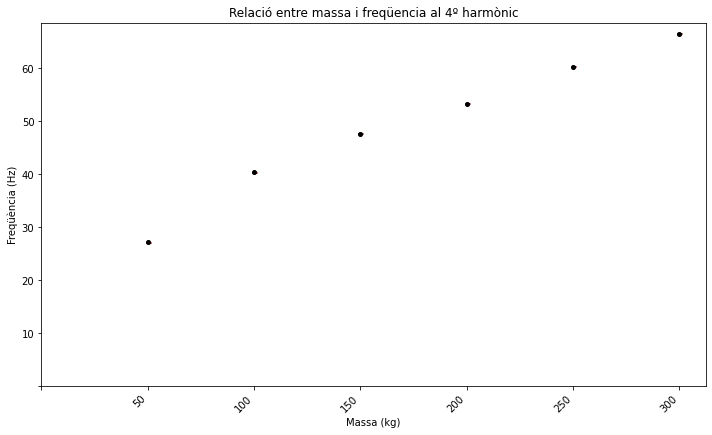

In [26]:
# Part 4: Visutalització de dades (Gràfiques)

# Suposam que tenim una sèrie de dades que volem posar en una gràfica
m1 = Measure("F_armonica_4_50", "F. armonica 4 (50)", [27.2, 0.1], "Hz")
m2 = Measure("F_armonica_4_100", "F. armonica 4 (100)", [40.4, 0.1], "Hz")
m3 = Measure("F_armonica_4_150", "F. armonica 4 (150)", [47.6, 0.1], "Hz")
m4 = Measure("F_armonica_4_200", "F. armonica 4 (200)", [53.3, 0.1], "Hz")
m5 = Measure("F_armonica_4_250", "F. armonica 4 (250)", [60.3, 0.1], "Hz")
m6 = Measure("F_armonica_4_300", "F. armonica 4 (300)", [66.5, 0.1], "Hz")

#Cal posar les dades en coordenades, no importa l'ordre
data = [
    (50, m1),
    (100, m2),
    (150, m3),
    (200, m4),
    (250, m5),
    (300, m6)
]
# Els paràmetres queden més clars després de veure el gràfic
graph_display(data,"Massa", "kg","Freqüència", "Hz", "Relació entre massa i freqüencia al 4º harmònic")

/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator


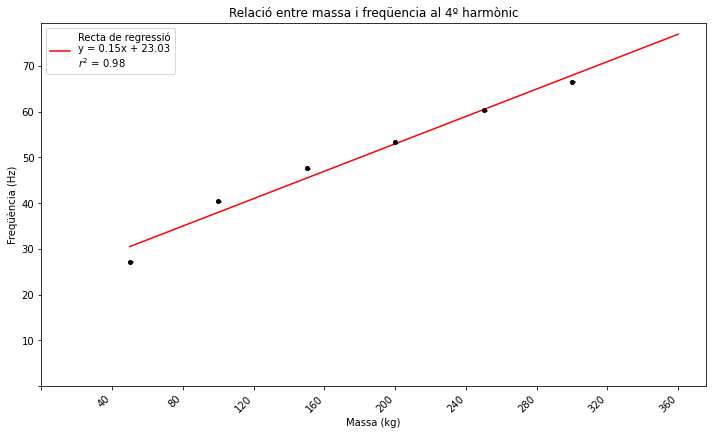

In [27]:
# Part 5: Crear una regressió lineal

# Veiem que és igual que abans
regre(data,"Massa", "kg","Freqüència", "Hz", "Relació entre massa i freqüencia al 4º harmònic")